#Major 2

##Part 1

In [2]:
from matplotlib import pylab
params = {'xtick.labelsize': 18,
          'ytick.labelsize': 18,
          'axes.titlesize' : 22,
          'axes.labelsize' : 20,
          'legend.fontsize': 18,
          'legend.title_fontsize': 22,
          'figure.titlesize': 24 }
pylab.rcParams.update(params)

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
!rm *.csv
from google.colab import files
uploadedData = files.upload()
filename = list(uploadedData)[0]
dataset = pd.read_csv(filename)

rm: cannot remove '*.csv': No such file or directory


Saving virus_data.csv to virus_data.csv


In [5]:
ds = dataset.copy()
ds.drop(columns = ['patient_id','pcr_date', 'current_location'], inplace=True)

In [6]:
from sklearn.model_selection import train_test_split
df = pd.DataFrame(ds)
training_data, testing_data = train_test_split(df, test_size = 0.2, random_state = 96)
missing_train = training_data.isnull().sum()
missing_test = testing_data.isnull().sum()
income_median = training_data['household_income'].median()
print("Income Median:", income_median)
training_data['household_income'].fillna(income_median, inplace = True)
testing_data['household_income'].fillna(income_median, inplace = True)

Income Median: 0.7


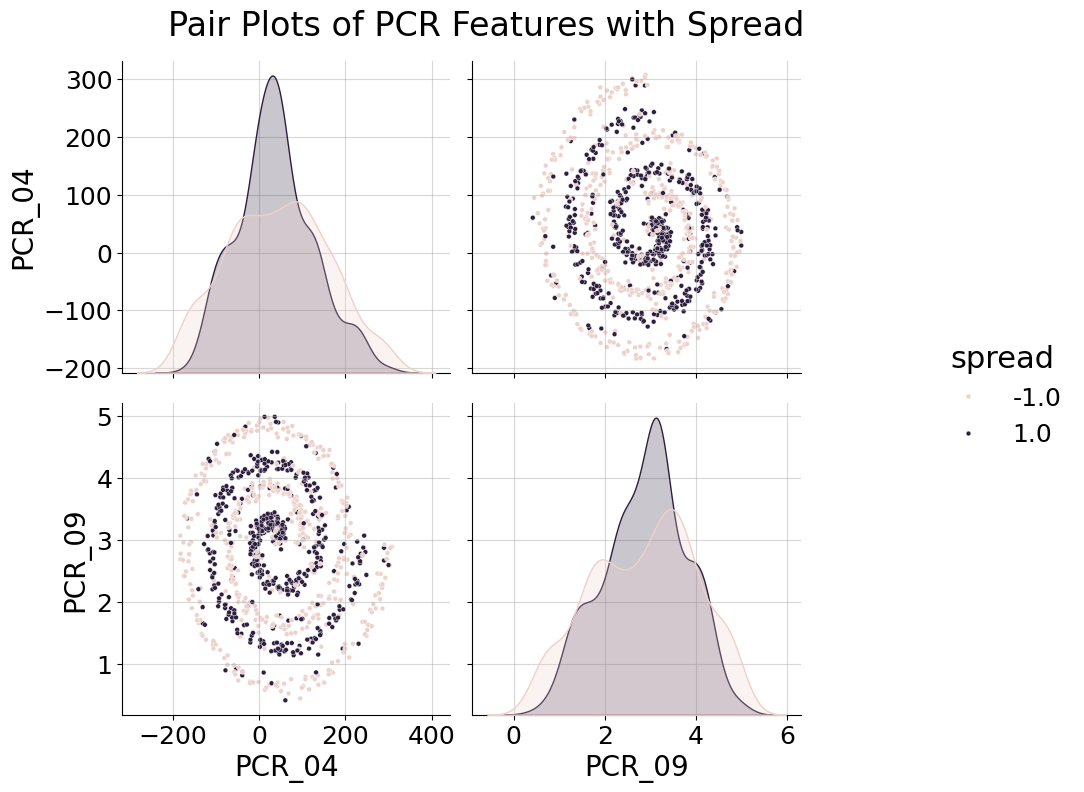

In [7]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

PCR_features = ['PCR_04', 'PCR_09']
pair_plot = sns.pairplot(training_data, vars = PCR_features, hue = 'spread', plot_kws={'s': 12})
pair_plot.fig.suptitle("Pair Plots of PCR Features with Spread", y=1.04)

for ax in pair_plot.axes.flatten():
    ax.grid(alpha = 0.5)

pair_plot.fig.set_size_inches(12, 8)
plt.show()

In [8]:
def visualize_clf(clf, X, Y, title,
                  xlabel, ylabel,
                  marker_size=50,
                  grid_length=300,
                  linewidths=None):
    import matplotlib.pyplot as plt
    import pandas as pd
    #added by Nick:
    import numpy as np

    from matplotlib.colors import ListedColormap

    if isinstance(X, pd.DataFrame):
        X = X.to_numpy()

    # For internal use here, make sure labels are 0 and 1
    Y = np.ravel(Y).astype(int)
    labels = set(Y)
    assert len(labels) == 2, "Can only visualize two unique labels"

    if labels == set([-1,1]):
      Y = (Y + 1) // 2
      labels = set(Y)

    assert labels == set([0,1]), "Could not handle given labels"

    plt.figure(figsize=(8, 8))

    # Parameters
    n_classes = 2
    markers = ["D", "o"]
    palette = sns.color_palette("hls", 2)
    custom_cmap = ListedColormap(palette.as_hex())

    x_delta = np.abs(X[:, 0].max() - X[:, 0].min()) * 0.1
    y_delta = np.abs(X[:, 1].max() - X[:, 1].min()) * 0.1
    x_min, x_max = X[:, 0].min() - x_delta, X[:, 0].max() + x_delta
    y_min, y_max = X[:, 1].min() - y_delta, X[:, 1].max() + y_delta
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, grid_length),
                         np.linspace(y_min, y_max, grid_length))
    plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    cs = plt.contourf(xx, yy, Z, cmap=custom_cmap, alpha=0.35)

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(alpha=0.75)

    # Plot the training points
    for i, color, marker in zip(labels, palette, markers):
        idx = np.where(Y == i)
        plt.scatter(X[idx, 0], X[idx, 1], color=color,
                    marker=marker,
                    edgecolor='white', s=marker_size,
                    linewidths=linewidths)

    plt.title(title, fontsize=20)
    plt.axis("tight")
    plt.show()


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


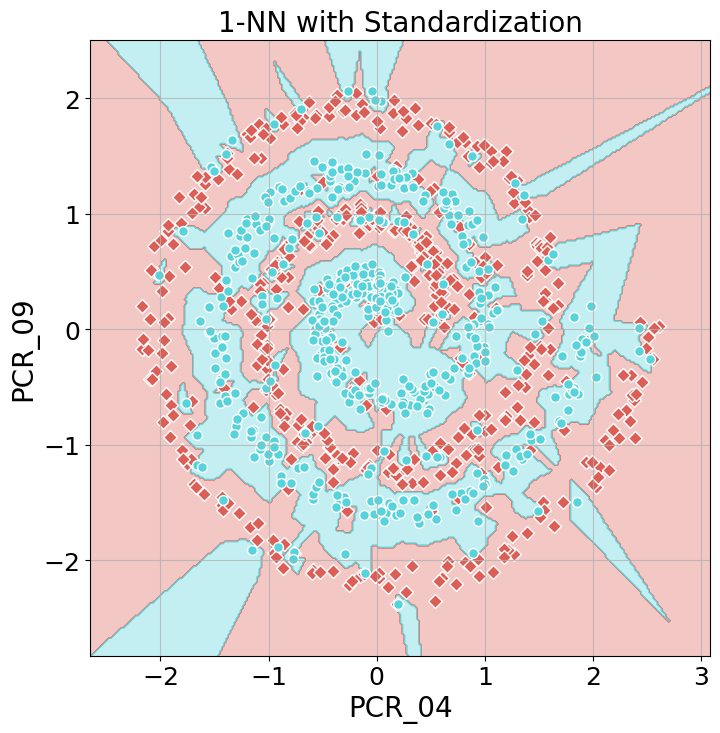

Test Accuracy: 0.7200


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


In [9]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

scaler = StandardScaler()
#scaler = MinMaxScaler()
training_data[['PCR_04', 'PCR_09']] = scaler.fit_transform(training_data[['PCR_04', 'PCR_09']])
testing_data[['PCR_04', 'PCR_09']] = scaler.transform(testing_data[['PCR_04', 'PCR_09']]) # fit_transform or transform?

temp_training_df = training_data[['PCR_04', 'PCR_09', 'spread']]

x_train = temp_training_df[['PCR_04', 'PCR_09']]
y_train = temp_training_df['spread']
knn = KNeighborsClassifier(n_neighbors = 1)
knn.fit(x_train, y_train)

x_train_np = x_train.to_numpy()
y_train_np = y_train.to_numpy()
visualize_clf(knn, x_train_np, y_train_np, '1-NN with Standardization',xlabel = 'PCR_04', ylabel = 'PCR_09')

#just to get the accuracy
X_test = testing_data[['PCR_04', 'PCR_09']].to_numpy()
y_test = testing_data['spread'].to_numpy()
y_pred = knn.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Test Accuracy: {accuracy:.4f}')


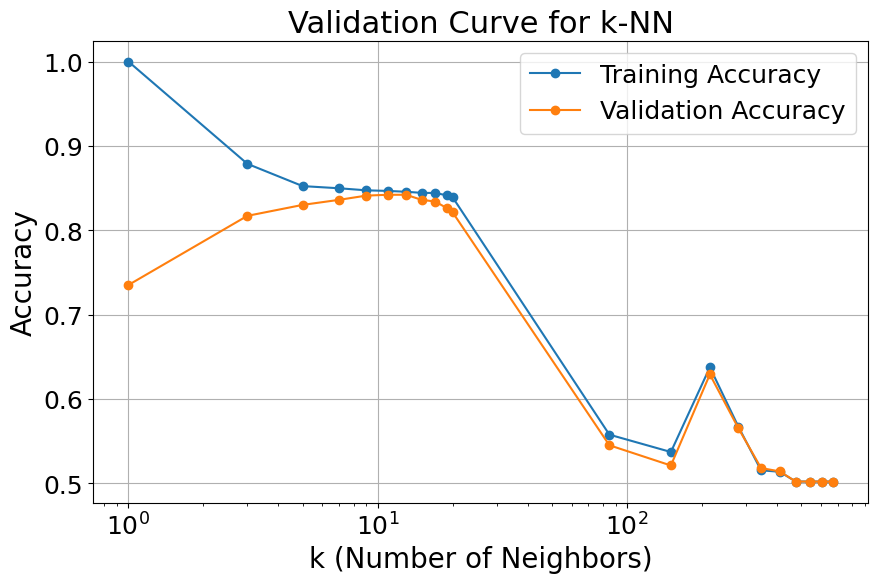

In [10]:
from sklearn.model_selection import cross_validate
X = training_data[['PCR_04', 'PCR_09']]
y = training_data['spread']
k_values = list(range(1, 20, 2)) + list(range(20, 695, 65))
train_scores = []
test_scores = []
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors = k)
    scores = cross_validate(knn, X, y, cv = 8, return_train_score = True, scoring = 'accuracy')
    train_scores.append(scores['train_score'].mean())
    test_scores.append(scores['test_score'].mean())

plt.figure(figsize=(10, 6))
plt.semilogx(k_values, train_scores, label='Training Accuracy', marker='o')
plt.semilogx(k_values, test_scores, label='Validation Accuracy', marker='o')
plt.xlabel('k (Number of Neighbors)')
plt.ylabel('Accuracy')
plt.title('Validation Curve for k-NN')
plt.legend()
plt.grid(True)
plt.show()

In [11]:
best_k_index = np.argmax(test_scores)
best_k = k_values[best_k_index]
best_train_score = train_scores[best_k_index]
best_test_score = test_scores[best_k_index]

print(f'Best k: {best_k}')
print(f'Average Training Accuracy: {best_train_score:.4f}')
print(f'Average Validation Accuracy: {best_test_score:.4f}')

Best k: 11
Average Training Accuracy: 0.8466
Average Validation Accuracy: 0.8420


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


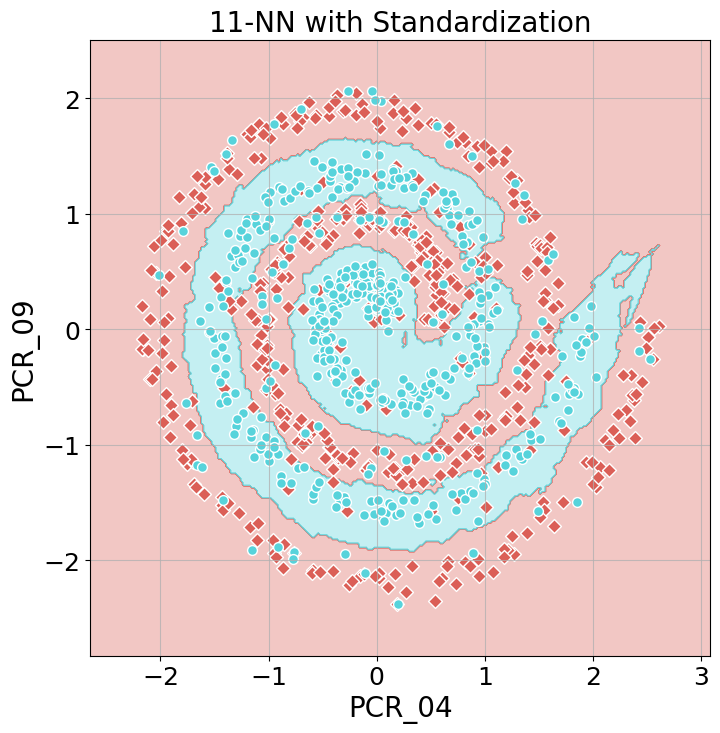

Test Accuracy: 0.8240


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


In [12]:
knn_opt = KNeighborsClassifier(n_neighbors = best_k)
knn_opt.fit(X, y)
visualize_clf(knn_opt, X, y, title = f'{best_k}-NN with Standardization', xlabel = 'PCR_04', ylabel = 'PCR_09')
X_test = testing_data[['PCR_04', 'PCR_09']].to_numpy()
y_test = testing_data['spread'].to_numpy()
y_pred = knn_opt.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Test Accuracy: {accuracy:.4f}')

##Part 2

In [13]:
training_data_p2 = training_data[['blood_type', 'PCR_03', 'PCR_10', 'risk']].copy()
training_data_p2['SpecialProperty'] = training_data_p2['blood_type'].isin(['O+', 'B+']).astype(int)
training_data_p2.drop(columns = ['blood_type'], inplace=True)
X = training_data_p2[['PCR_03', 'PCR_10', 'SpecialProperty']]
y = training_data_p2['risk']

Training Accuracy: 0.69


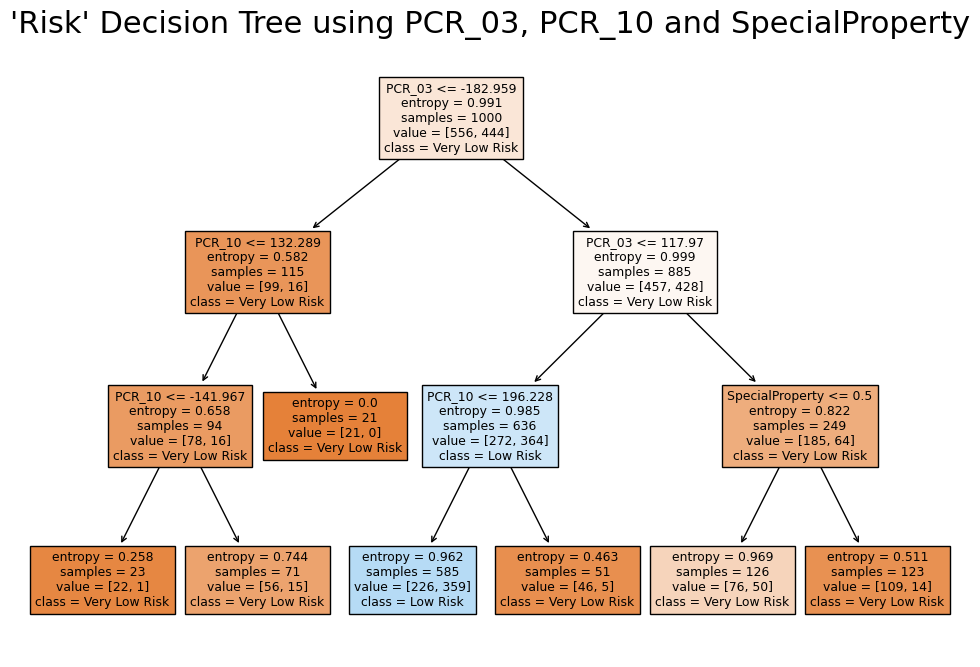

In [14]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
dt = DecisionTreeClassifier(criterion = 'entropy', max_depth = 3)
dt.fit(X, y)
y_pred = dt.predict(X)
training_accuracy = accuracy_score(y, y_pred)
print(f'Training Accuracy: {training_accuracy:.2f}')

# Visualize the tree
plt.figure(figsize=(12, 8))
plot_tree(dt, feature_names = ['PCR_03', 'PCR_10', 'SpecialProperty'], class_names = ['Very Low Risk', 'Low Risk', 'Mid Risk', 'High Risk', 'Very High Risk'], filled=True)
plt.title('\'Risk\' Decision Tree using PCR_03, PCR_10 and SpecialProperty')
plt.show()

In [15]:
from sklearn.model_selection import GridSearchCV
#tune 'min_samples_leaf' & 'max_depth' to get the best validation error for predicting 'risk'
dt = DecisionTreeClassifier(criterion='entropy')
param_grid = {
    'min_samples_leaf': list(range(1,20,2)) + list(range(50,301,50)),
    'max_depth': list(range(1,20,2))
}
grid_search = GridSearchCV(dt, param_grid, cv=5, scoring='accuracy', return_train_score = True)
grid_search.fit(X, y)

best_params = grid_search.best_params_
best_score = grid_search.best_score_
print("Best Parameters:", best_params)
print("Best Score:", best_score)


Best Parameters: {'max_depth': 11, 'min_samples_leaf': 5}
Best Score: 0.818


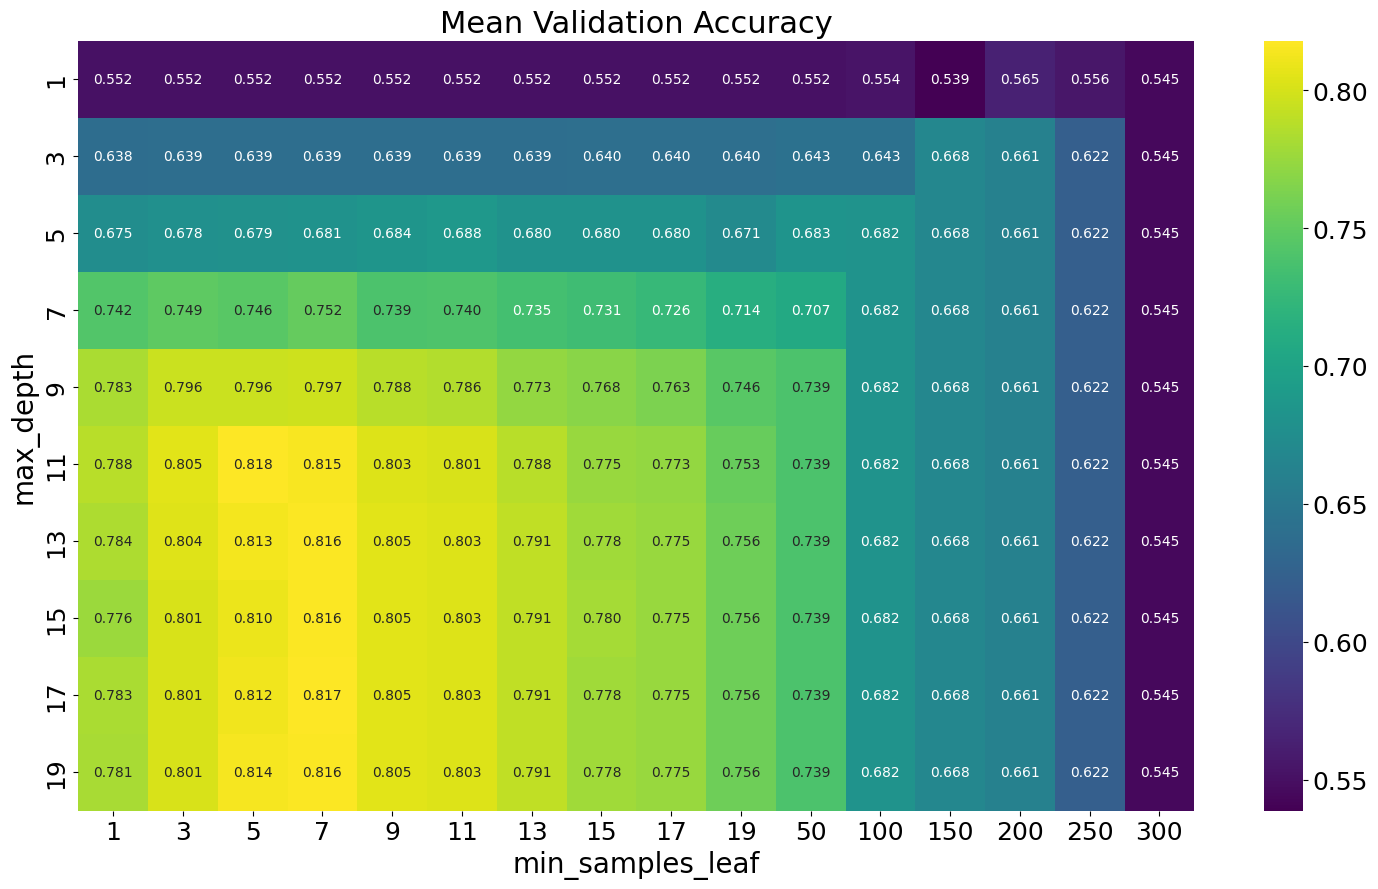

In [16]:
results = pd.DataFrame(grid_search.cv_results_)
mean_validation_scores  = results.pivot_table(index='param_max_depth', columns='param_min_samples_leaf', values='mean_test_score')
plt.figure(figsize=(18, 10))
sns.heatmap(mean_validation_scores , annot=True, cmap='viridis', fmt='.3f')
plt.title('Mean Validation Accuracy')
plt.xlabel('min_samples_leaf')
plt.ylabel('max_depth')
plt.show()

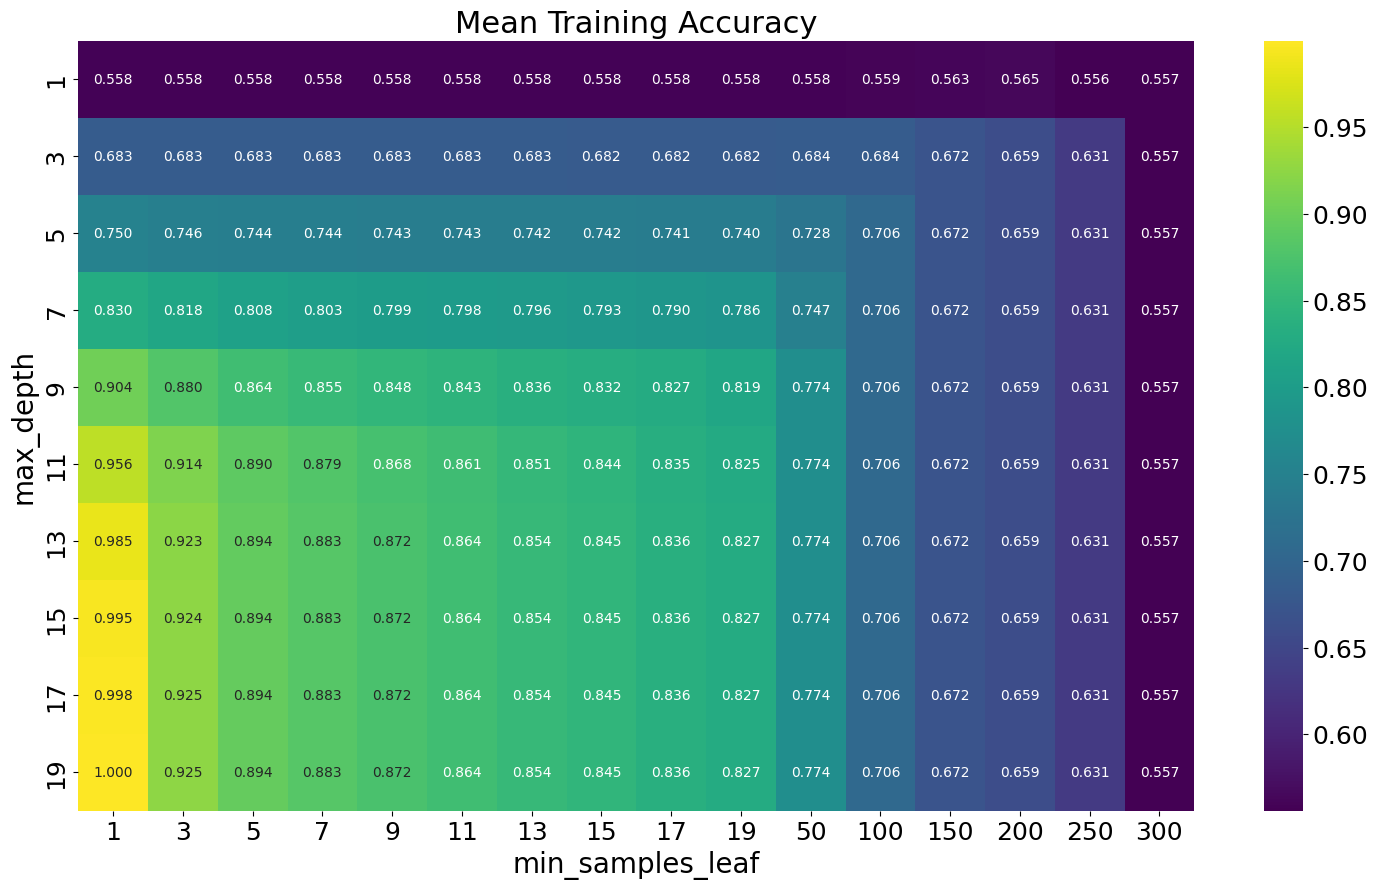

In [17]:
mean_training_scores  = results.pivot_table(index='param_max_depth', columns='param_min_samples_leaf', values='mean_train_score')
plt.figure(figsize=(18, 10))
sns.heatmap(mean_training_scores , annot=True, cmap='viridis', fmt='.3f')
plt.title('Mean Training Accuracy')
plt.xlabel('min_samples_leaf')
plt.ylabel('max_depth')
plt.show()

In [18]:
difference = mean_training_scores - mean_validation_scores

# Find the maximum difference
max_difference = np.unravel_index(np.argmax(difference.values, axis=None), difference.shape)
max_diff_params = difference.index[max_difference[0]], difference.columns[max_difference[1]]

# Display the maximum difference and corresponding parameters
print("Maximum Difference:", difference.values[max_difference])
print("Best Parameters for Maximum Difference:", max_diff_params)

Maximum Difference: 0.21875
Best Parameters for Maximum Difference: (15, 1)


In [19]:
testing_data_p2 = testing_data[['blood_type', 'PCR_03', 'PCR_10', 'risk']].copy()
testing_data_p2['SpecialProperty'] = testing_data_p2['blood_type'].isin(['O+', 'B+']).astype(int)
testing_data_p2.drop(columns = ['blood_type'], inplace=True)
X_test = testing_data_p2[['PCR_03', 'PCR_10', 'SpecialProperty']]
y_test = testing_data_p2['risk']
opt_dt = DecisionTreeClassifier(criterion='entropy', max_depth=11, min_samples_leaf=7)
opt_dt.fit(X, y)
y_pred = opt_dt.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)
print(f'Test Accuracy: {test_accuracy:.4f}')

Test Accuracy: 0.8520


##Part 3

soft SVM import:

In [20]:
from sklearn.base import BaseEstimator, ClassifierMixin
import numpy as np

class SoftSVM(BaseEstimator, ClassifierMixin):
    """
    Custom C-Support Vector Classification.
    """
    def __init__(self, C: float, lr: float = 1e-5, batch_size = 32):
        """
        Initialize an instance of this class.
        ** Do not edit this method **

        :param C: inverse strength of regularization. Must be strictly positive.
        :param lr: the SGD learning rate (step size)
        """
        self.C = C
        self.lr = lr
        self.batch_size = batch_size
        self.w = None
        self.b = 0.0

    # Initialize a random weight vector
    def init_solution(self, n_features: int):
        """
        Randomize an initial solution (weight vector)
        ** Do not edit this method **

        :param n_features:
        """
        self.w = np.random.randn(n_features)
        self.b = 0.0

    @staticmethod
    def loss(w, b: float, C: float, X, y):
        """
        Compute the SVM objective loss.

        :param w: weight vector for linear classification; array of shape (n_features,)
        :param b: bias scalar for linear classification
        :param C: inverse strength of regularization. Must be strictly positive.
        :param X: samples for loss computation; array of shape (n_samples, n_features)
        :param y: targets for loss computation; array of shape (n_samples,)
        :return: the Soft SVM objective loss (float scalar)
        """
        margins = (X.dot(w) + b).reshape(-1, 1)
        hinge_inputs = np.multiply(margins, y.reshape(-1, 1))

        norm = np.linalg.norm(w)

        hinge_loss = np.maximum(0,1-hinge_inputs)
        loss = norm**2 + C * np.sum(hinge_loss)

        return loss

    @staticmethod
    def subgradient(w, b: float, C: float, X, y):
        """
        Compute the (analytical) SVM objective sub-gradient.

        :param w: weight vector for linear classification; array of shape (n_features,)
        :param b: bias scalar for linear classification
        :param C: inverse strength of regularization. Must be strictly positive.
        :param X: samples for loss computation; array of shape (n_samples, n_features)
        :param y: targets for loss computation; array of shape (n_samples,)
        :return: a tuple with (the gradient of the weights, the gradient of the bias)
        """
        margins = y * (np.dot(X,w) + b)
        mask = margins < 1
        g_w = 2 * w - C * np.dot(X[mask].T, y[mask])
        g_b = -C * np.sum(y[mask])

        return g_w, g_b

    def fit_with_logs(self, X, y, max_iter: int = 2000, keep_losses: bool = True):
        """
        Fit the model according to the given training data.

        :param X: training samples; array of shape (n_samples, n_features)
        :param y: training targets (+1 and -1); array of shape (n_samples,)
        :param max_iter: number of SGD iterations
        :param keep_losses:
        :return: the training losses and accuracies during training
        """
        # Initialize learned parameters
        self.init_solution(X.shape[1])

        losses = []
        accuracies = []

        if keep_losses:
            losses.append(self.loss(self.w, self.b, self.C, X, y))
            accuracies.append(self.score(X, y))

        permutation = np.random.permutation(len(y))
        X = X[permutation, :]
        y = y[permutation]

        # Iterate over batches
        for iter in range(0, max_iter):
            start_idx = (iter * self.batch_size) % X.shape[0]
            end_idx = min(X.shape[0], start_idx + self.batch_size)
            batch_X = X[start_idx:end_idx, :]
            batch_y = y[start_idx:end_idx]

            #Compute the (sub)gradient of the current *batch*
            g_w, g_b = self.subgradient(self.w, self.b, self.C, batch_X, batch_y)

            # Perform a (sub)gradient step
            self.w = self.w - self.lr * g_w
            self.b = self.b - self.lr * g_b

            if keep_losses:
                losses.append(self.loss(self.w, self.b, self.C, X, y))
                accuracies.append(self.score(X, y))

        return losses, accuracies

    def fit(self, X, y, max_iter: int = 2000):
        """
        Fit the model according to the given training data.
        ** Do not edit this method **

        :param X: training samples; array of shape (n_samples, n_features)
        :param y: training targets (+1 and -1); array of shape (n_samples,)
        :param max_iter: number of SGD iterations
        """
        self.fit_with_logs(X, y, max_iter=max_iter, keep_losses=False)

        return self

    def predict(self, X):
        """
        Perform classification on samples in X.

        :param X: samples for prediction; array of shape (n_samples, n_features)
        :return: Predicted class labels for samples in X; array of shape (n_samples,)
                 NOTE: the labels must be either +1 or -1
        """
        raw_pred = np.dot(X, self.w) + self.b
        pred = np.sign(raw_pred)
        pred[pred == 0] = 1
        return pred

verify_gradients.py:

In [21]:
def numerical_subgradient(w, b, C, X, y, delta=1e-4):
    w_ = w.copy()
    g_w = np.zeros_like(w_)
    orig_objective = SoftSVM.loss(w_, b, C, X, y)
    for i in range(g_w.shape[0]): # go over each cell of g_w?
        w_[i] += delta # add delta to each cell of w_?
        perturbed_objective = SoftSVM.loss(w_, b, C, X, y) #calculate loss on (w_ + delta)?s
        w_[i] -= delta #subtract delta from w_?
        g_w[i] = (perturbed_objective - orig_objective) / delta # derivative formula for w?

    g_b = (SoftSVM.loss(w_, b + delta, C, X, y) - orig_objective) / delta #derivative formula for b?
    return g_w, g_b



def compare_gradients(X, y, deltas, C=1, REPEATS=100, figsize=(10, 6)):
    residual_means = []

    for delta in deltas:
        residuals = []

        for _ in range(REPEATS):
            # Randomize vectors in which the gradient is computed
            w = np.random.randn(X.shape[1])
            b = np.random.randn(1)

            # Compute the two types of gradients
            analytic_grad = SoftSVM.subgradient(w, b, C, X, y)[0]
            numeric_grad = numerical_subgradient(w, b, C, X, y, delta=delta)[0]

            residual = np.linalg.norm(numeric_grad - analytic_grad)
            residuals.append(residual)

        residual_means.append(np.mean(residuals))

    plt.figure(figsize=figsize)
    plt.title('Residuals of analytical and numerical gradients', fontsize=22)
    plt.plot(deltas, residual_means, linewidth=3)
    plt.yscale('log')
    plt.xscale('log')
    plt.xlabel('$\delta$', fontsize=18)
    plt.ylabel(r'$\left\Vert \nabla_{w}p_{C}\left(w,b\right) - u_{\delta} \left(w,b\right)\right\Vert$', fontsize=18)

    plt.grid(alpha=0.5)
    plt.show()


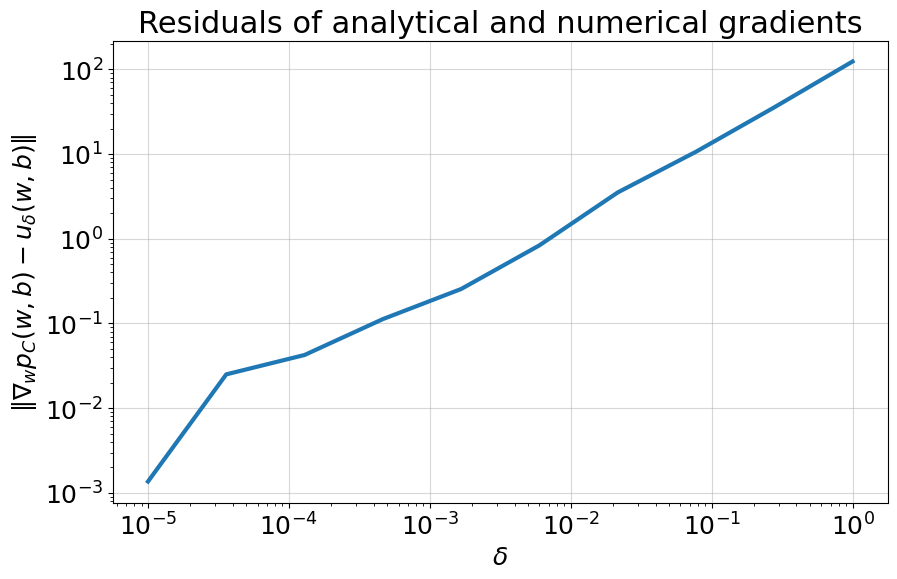

In [22]:
X_train = training_data[['PCR_04', 'PCR_09']].to_numpy()
y_train = training_data['spread'].to_numpy()
compare_gradients(X_train, y_train, deltas=np.logspace(-5, 0, 10))

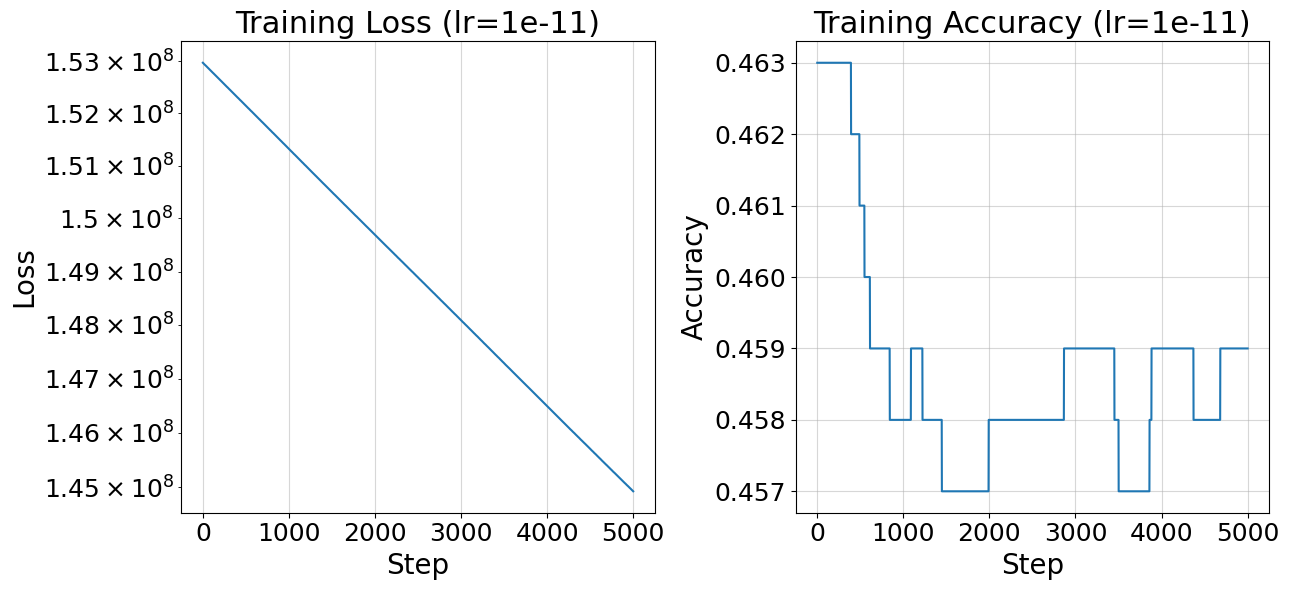

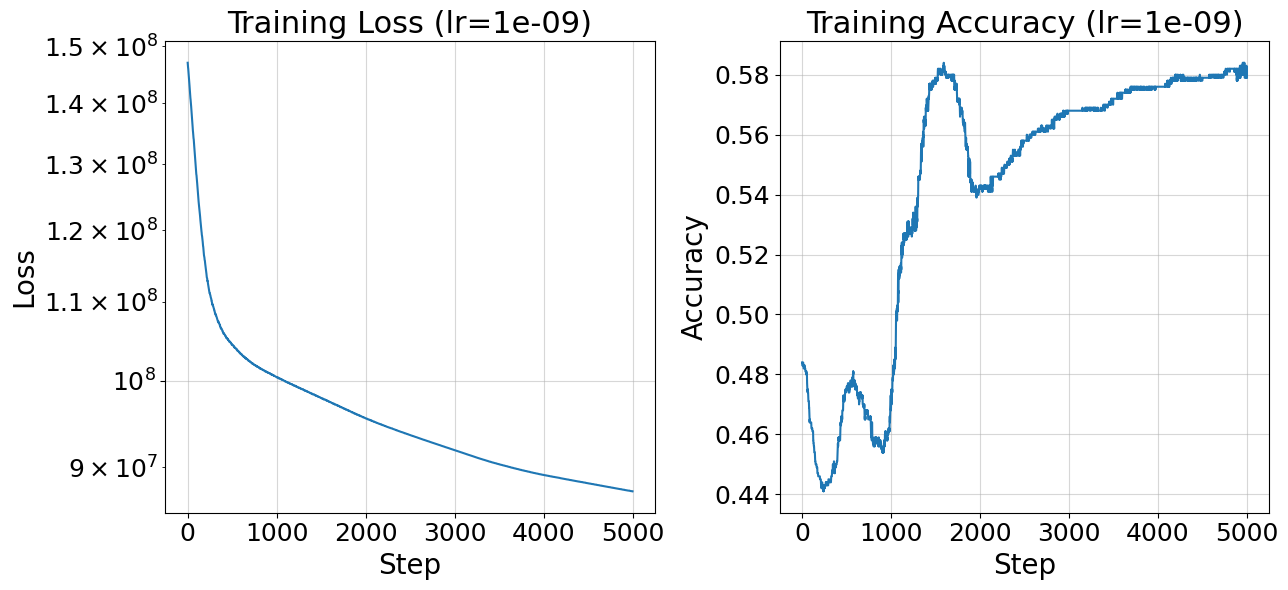

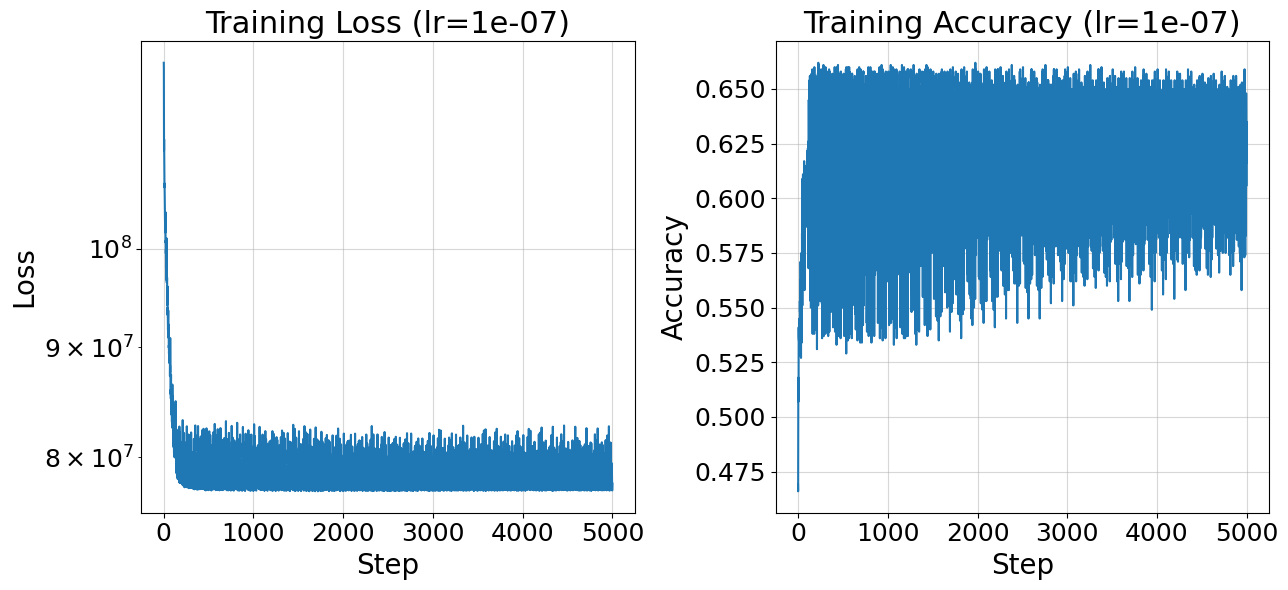

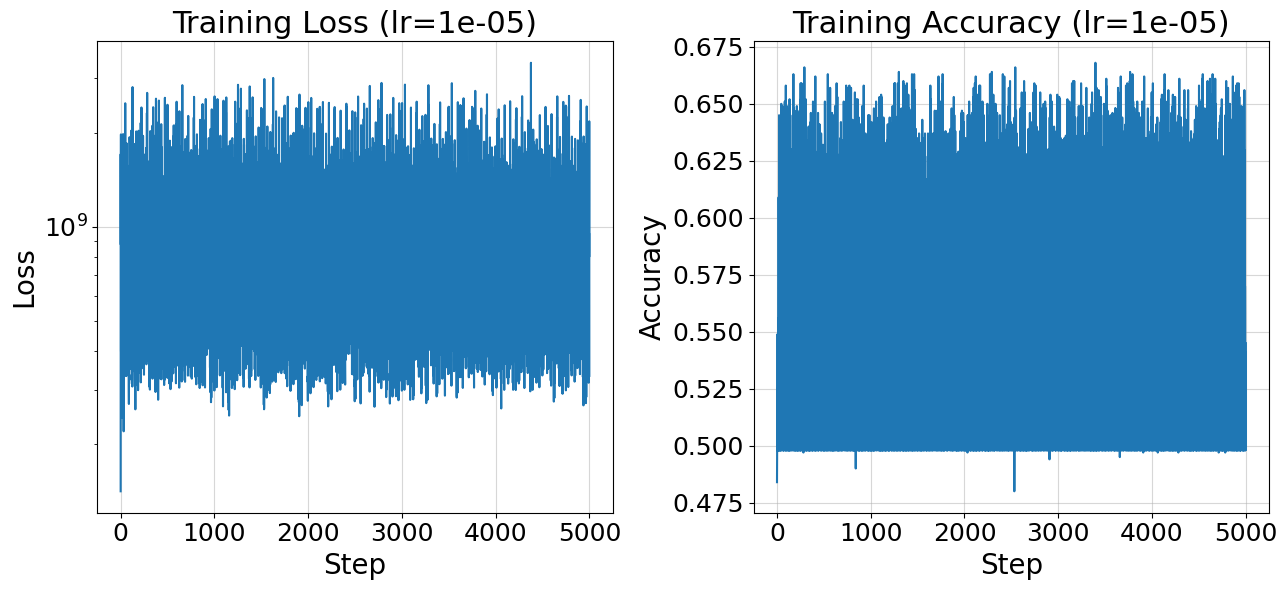

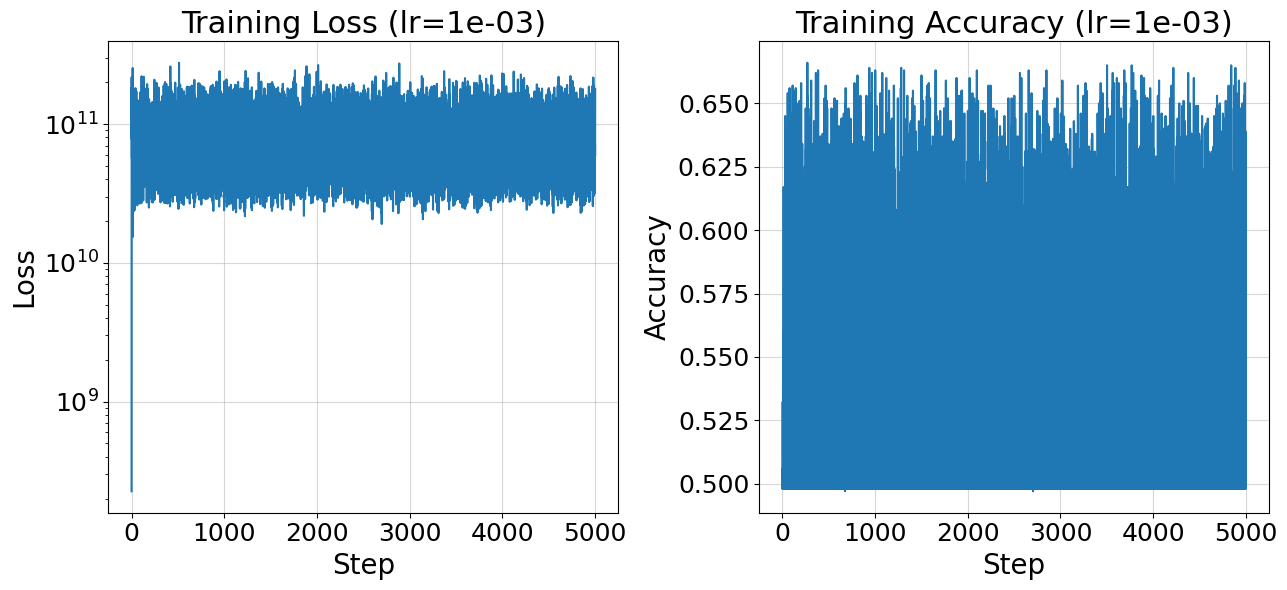

In [23]:
from sklearn.preprocessing import PolynomialFeatures
C=1e5
learning_rates = np.logspace(-11, -3, 5)
X_train_poly = PolynomialFeatures(degree=3,).fit_transform(X_train)
X_train_poly = MinMaxScaler(feature_range=(-1,1)).fit_transform(X_train_poly)
for i, lr in enumerate(learning_rates):
    clf = SoftSVM(C=C, lr=lr)
    losses, accuracies = clf.fit_with_logs(X_train_poly, y_train, max_iter=5000)
    plt.figure(figsize=(13, 6))
    plt.subplot(121), plt.grid(alpha=0.5), plt.title ("Training Loss"), plt.title(f"Training Loss (lr={lr:.0e})")
    plt.semilogy(losses), plt.xlabel("Step"), plt.ylabel("Loss")
    plt.subplot(122), plt.grid(alpha=0.5), plt.title ("Training Accuracy"), plt.title(f"Training Accuracy (lr={lr:.0e})")
    plt.plot(accuracies), plt.xlabel("Step"), plt.ylabel("Accuracy")

    plt.tight_layout()
plt.show()


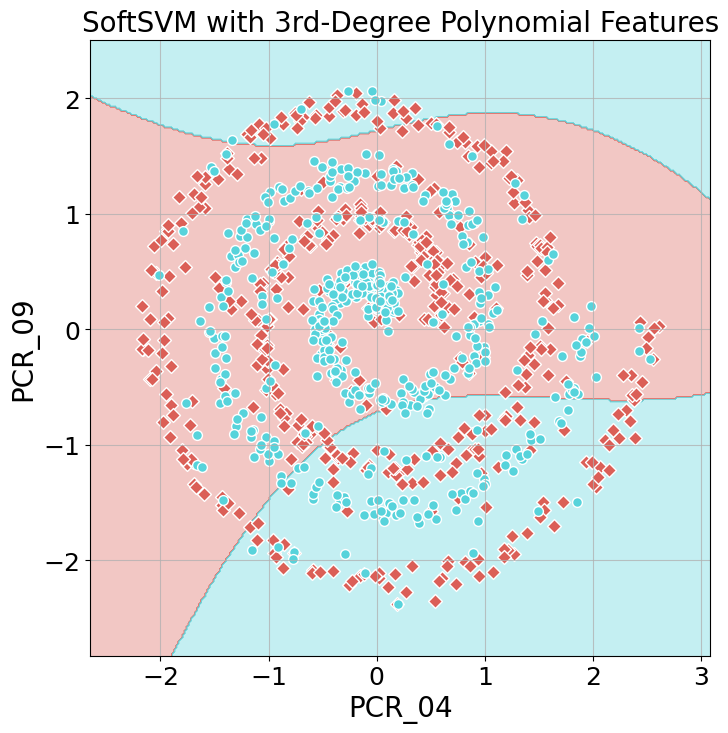

Training Accuracy: 0.43
Test Accuracy: 0.46


In [24]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
svm_clf = Pipeline([('feature_mapping', PolynomialFeatures(degree = 3)),
('scaler', MinMaxScaler()),
('SVM', SoftSVM(C=1e5, lr=1e-09))])
svm_clf.fit(X_train, y_train)
visualize_clf(svm_clf, X_train, y_train, title='SoftSVM with 3rd-Degree Polynomial Features', xlabel='PCR_04', ylabel='PCR_09')

train_accuracy = svm_clf.score(X_train, y_train)

X_test = testing_data[['PCR_04', 'PCR_09']].to_numpy()
y_test = testing_data['spread'].to_numpy()
test_accuracy = svm_clf.score(X_test, y_test)

print(f"Training Accuracy: {train_accuracy :.2f}")
print(f"Test Accuracy: {test_accuracy :.2f}")

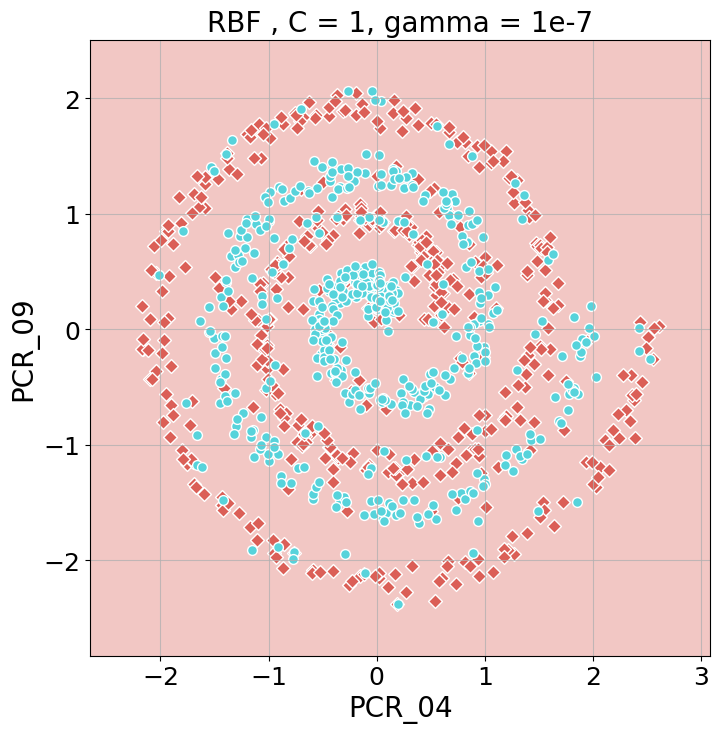

Training Accuracy: 0.50
Test Accuracy: 0.49


In [25]:
from sklearn.svm import SVC
svm_model = SVC(kernel='rbf', C=1.0, gamma=1e-7)
svm_model.fit(X_train, y_train)

visualize_clf(svm_model, X_train, y_train, title='RBF , C = 1, gamma = 1e-7', xlabel='PCR_04', ylabel='PCR_09')
train_accuracy = svm_model.score(X_train, y_train)

X_test = testing_data[['PCR_04', 'PCR_09']].to_numpy()
y_test = testing_data['spread'].to_numpy()
test_accuracy = svm_model.score(X_test, y_test)

print(f"Training Accuracy: {train_accuracy :.2f}")
print(f"Test Accuracy: {test_accuracy :.2f}")

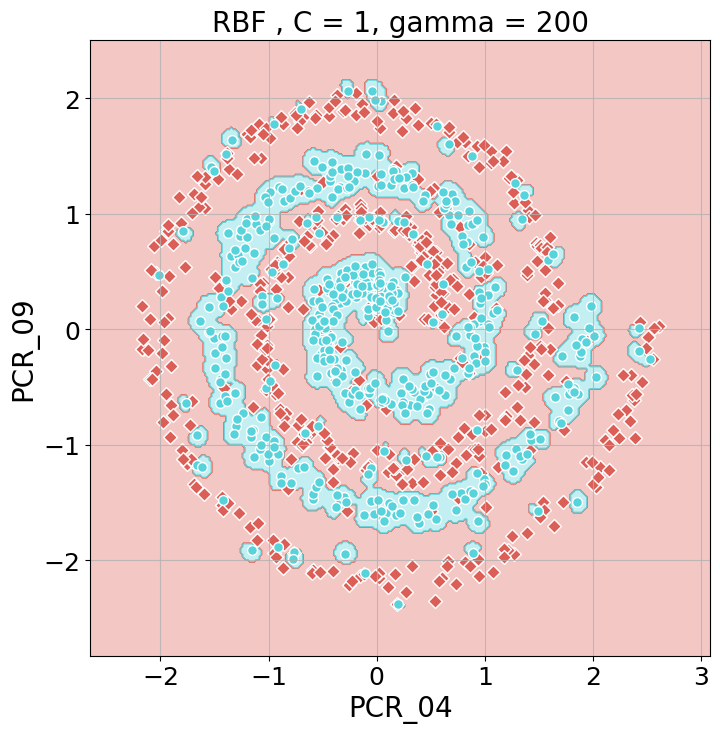

Training Accuracy: 0.92
Test Accuracy: 0.72


In [26]:
from sklearn.svm import SVC
svm_model = SVC(kernel='rbf', C=1.0, gamma=200)
svm_model.fit(X_train, y_train)

visualize_clf(svm_model, X_train, y_train, title='RBF , C = 1, gamma = 200', xlabel='PCR_04', ylabel='PCR_09')
train_accuracy = svm_model.score(X_train, y_train)

X_test = testing_data[['PCR_04', 'PCR_09']].to_numpy()
y_test = testing_data['spread'].to_numpy()
test_accuracy = svm_model.score(X_test, y_test)

print(f"Training Accuracy: {train_accuracy :.2f}")
print(f"Test Accuracy: {test_accuracy :.2f}")

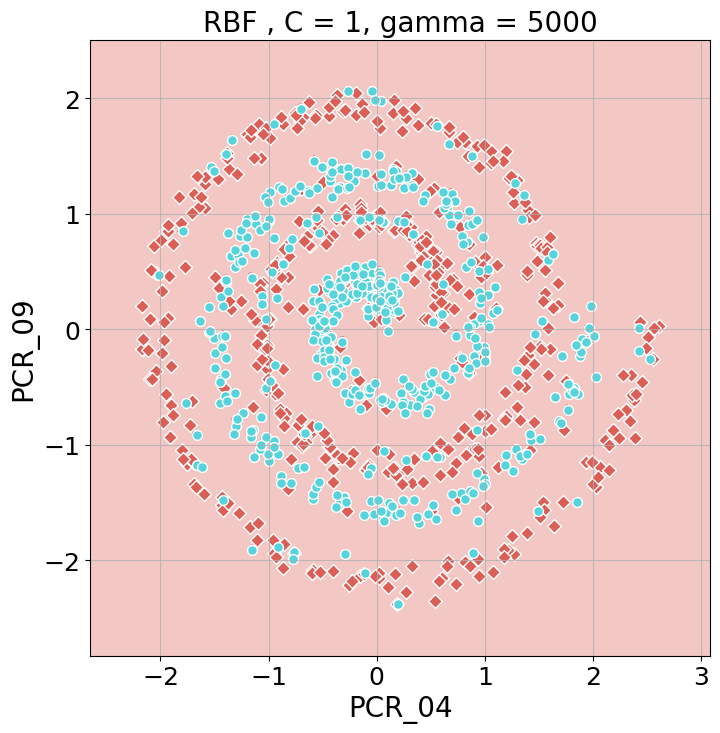

Training Accuracy: 1.00
Test Accuracy: 0.60


In [27]:
from sklearn.svm import SVC
svm_model = SVC(kernel='rbf', C=1.0, gamma=5000)
svm_model.fit(X_train, y_train)

visualize_clf(svm_model, X_train, y_train, title='RBF , C = 1, gamma = 5000', xlabel='PCR_04', ylabel='PCR_09')
train_accuracy = svm_model.score(X_train, y_train)

X_test = testing_data[['PCR_04', 'PCR_09']].to_numpy()
y_test = testing_data['spread'].to_numpy()
test_accuracy = svm_model.score(X_test, y_test)

print(f"Training Accuracy: {train_accuracy :.2f}")
print(f"Test Accuracy: {test_accuracy :.2f}")